# Project - Making Estimations with our NBA dataset

The goals of this project are:
- Define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, f1_score
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDRegressor, LogisticRegression 
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# To test the models with different random states
randomness = 42

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)

Let's have another look at our previously generated dataset. 

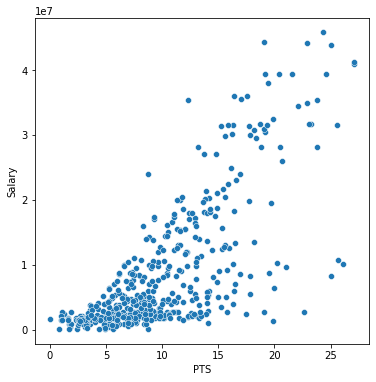

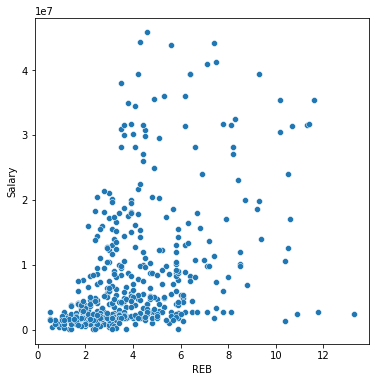

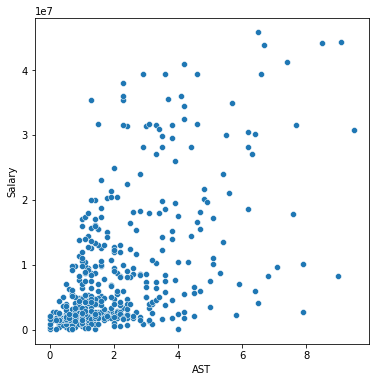

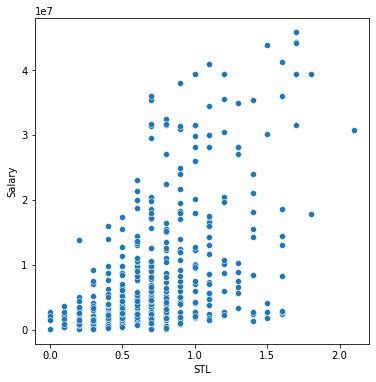

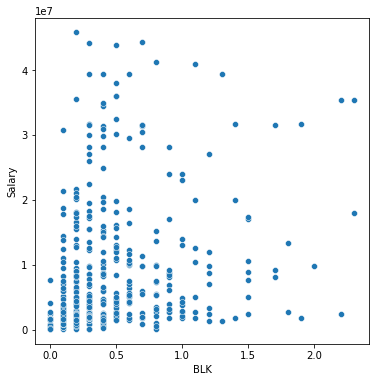

In [ ]:
''' Definitions:
        PTS = Average numbers points per game
        REB = Average numbers rebounds per game
        AST = Average numbers assists per game
        STL = Average numbers steals per game
        BLK = Avergae numbers blocks per game
'''

features = ["PTS", "REB", "AST", "STL", "BLK"]
plt.rcParams['figure.figsize'] = [6, 6]

for feature in features:
    sns.scatterplot(data=data, x=feature, y="Salary")
    plt.show()

1.2. What can we say about these distributions?

We can see in the different plots that some stats have positive correlation
with the salary of the player. The players average number of points per game
seems like the most promising feature to predict the salary of a player,
while others like the number of blocks doesn't seem particular helpful in
that regard.

Notably the considered features are in some way magnitudes of the players
'activeness' in the game, ways of the players to change the course of the
game.

### Splitting the Dataset

In [ ]:
y = data["Salary"]
X = data.drop(axis=1, labels="Salary")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomness)

### Baseline Model and Evaluation Metric

Creating a Baseline model class that implements fit() and predict() methods. The baseline model will consider just the average salary for making the predictions.

In [ ]:
class BaselineModel():
    """ A baseline model that always returns the same value,
    the mean of the players salary in the train data. """

    def fit(self, y_train):
        """ Fit the training data with a simple baseline method.
        
        Parameters
        ----------
        y_train: A pandas series [pd.Series] or numpy array [np.ndarray]
                 containing salary information.
        """
        
        self.mean_salary = y_train.mean()
        
    
    def predict(self, X_test):
        """ Predict salaries returning the average players salary of the train data.
        
        Parameters
        ----------
        X: A pandas series [pd.Series], a Pandas dataframe [pd.DataFrame]
           or numpy array [np.ndarray] with the data we want to predict from.
        
        Returns
        -------
        np.ndarray: a numpy array of the same length as X, with all elements
                    equal to the mean salary calculated in fit().
        """
        
        return np.array([self.mean_salary] * X_test.shape[0])

In [ ]:
# Evaluation of the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn
base_model = BaselineModel()
base_model.fit(y_train)
y_pred = base_model.predict(X_test)

mae_1 = round(mean_absolute_error(y_test, y_pred))
print(mae_1)

6905402


### Regression with a single variable

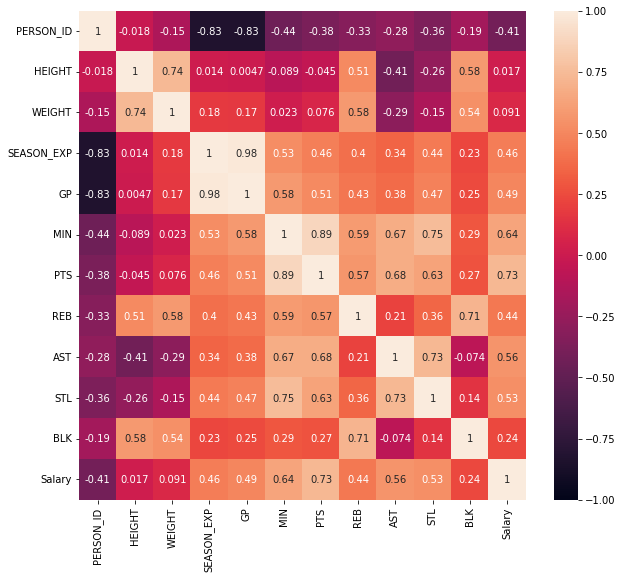

In [ ]:
plt.rcParams['figure.figsize'] = [10, 9]
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

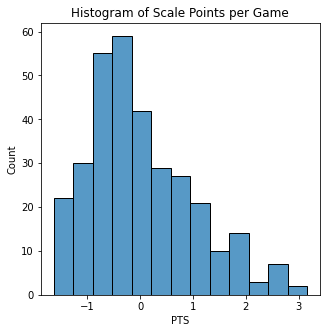

In [ ]:
# The feature "PTS" is selected due to having more correlation with the target (0.73).

s_scaler = StandardScaler()
X_train["PTS"] = s_scaler.fit_transform(X_train["PTS"].values.reshape(-1, 1))
X_test["PTS"]  = s_scaler.transform(X_test["PTS"].values.reshape(-1, 1))

plt.rcParams['figure.figsize'] = [5, 5]
sns.histplot(X_train, x="PTS").set(title="Histogram of Scale Points per Game")
plt.show()

In [ ]:
reg_model = SGDRegressor(random_state = randomness)
reg_model.fit(X_train["PTS"].values.reshape(-1, 1), y_train)
y_pred_2 = reg_model.predict(X_test["PTS"].values.reshape(-1, 1))

mae_2 = round(mean_absolute_error(y_test, y_pred_2))
print(mae_2)      # Less error than our baseline

4661663


In [ ]:
def search_best_hyperparameters(max_iter, eta0):
    '''
    Search for the best combination of hyperparameter with the given
    values in the arguments.

    Parameters
    ----------
    Python lists with the values of max_iter and eta0 to try onto the model.
    '''

    result = {
        "hyperparameters": {"max_iter": None, "eta0": None}, 
        "mae": None
    }

    for iter in max_iter:
        for eta in eta0:
            reg_model = SGDRegressor(max_iter=iter, eta0=eta, random_state = randomness)
            reg_model.fit(X_train["PTS"].values.reshape(-1, 1), y_train)
            y_pred = reg_model.predict(X_test["PTS"].values.reshape(-1, 1))

            mae = mean_absolute_error(y_test, y_pred)

            if result["mae"] == None or mae < result["mae"]:
                result["mae"] = round(mae)
                result["hyperparameters"]["max_iter"] = iter
                result["hyperparameters"]["eta0"] = eta

    return result

In [ ]:
max_iter = [500, 800, 1000, 5000, 10000, 100000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(max_iter, eta0)
print(result)

{'hyperparameters': {'max_iter': 800, 'eta0': 0.0001}, 'mae': 4547240}


In [ ]:
print("Mean Absolute Error for each model:")
print("Baseline:".ljust(25), mae_1)
print("Default SGDRegressor:".ljust(25), mae_2)
print("Best SGDRegressor:".ljust(25), result['mae'])

Mean Absolute Error for each model:
Baseline:                 6905402
Default SGDRegressor:     4661663
Best SGDRegressor:        4547240


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


In [ ]:
data_2 = data[["PERSON_ID", "PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "Salary"]]
data_2.set_index("PERSON_ID", drop=True, inplace=True)

#### Feature Engineering

Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted

In [ ]:
data_2["DRAFT_NUMBER"] = data_2["DRAFT_NUMBER"].fillna("Undrafted")
data_2["DRAFT_NUMBER"] = data_2["DRAFT_NUMBER"].replace("Undrafted", 0)
data_2["DRAFT_NUMBER"] = data_2["DRAFT_NUMBER"].astype(int)

data_2["DRAFT"] = pd.cut(data_2["DRAFT_NUMBER"], bins=[-1, 0, 15, 30, 60],
                 labels=["undrafted", "firstround_lottery", "firstround_non_lottery", "second_round"])

data_2.drop(axis=1, labels="DRAFT_NUMBER", inplace=True)

In [ ]:
data_2 = pd.get_dummies(data=data_2, columns=["DRAFT", "POSITION", "TEAM_NAME"])

y = data_2["Salary"]
X = data_2.drop(axis=1, labels="Salary")

In [ ]:
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomness)

In [ ]:
# Feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number
scaling_features = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]

scaler = StandardScaler()
X_train[scaling_features] = scaler.fit_transform(X_train[scaling_features])
X_test[scaling_features]  = scaler.transform(X_test[scaling_features])

In [ ]:
def search_best_hyperparameters_2(max_iter, eta0):
    '''
    Search for the best combination of hyperparameter with the given
    values in the arguments.

    Parameters
    ----------
    Python lists with the values of max_iter and eta0 to try onto the model.
    '''

    result = {
        "hyperparameters": {"max_iter": None, "eta0": None}, 
        "mae": None
    }

    for iter in max_iter:
        for eta in eta0:
            reg_model = SGDRegressor(max_iter=iter, eta0=eta, random_state = randomness)
            reg_model.fit(X_train, y_train)
            y_pred = reg_model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)

            if result["mae"] == None or mae < result["mae"]:
                result["mae"] = round(mae)
                result["hyperparameters"]["max_iter"] = iter
                result["hyperparameters"]["eta0"] = eta

    return result

max_iter = [500, 800, 1000, 5000, 10000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result_mult = search_best_hyperparameters_2(max_iter, eta0)

print(result)

{'hyperparameters': {'max_iter': 800, 'eta0': 0.0001}, 'mae': 4547240}


In [ ]:
print("Mean Absolute Error for each model:")
print("Baseline:".ljust(35), mae_1)
print("Default SGDRegressor:".ljust(35), mae_2)
print("Best SGDRegressor:".ljust(35), result['mae'])
print("Best SGDRegressor multivariable:".ljust(35), result_mult['mae'])

# The mean absolute error is greater in the multivariable SGDRegressor than our
# best prediction. Since our error had increased it is possible that some
# features haven't relation with the target (ex: team names). 

Mean Absolute Error for each model:
Baseline:                           6905402
Default SGDRegressor:               4661663
Best SGDRegressor:                  4547240
Best SGDRegressor multivariable:    4715385


### DecisionTreeRegressor

In [ ]:
def search_best_hyperparameters_3(max_depth, min_samples_leaf, max_features):
    '''
    Search for the best combination of hyperparameter with the given
    values in the arguments.

    Parameters
    ----------
    Python lists with the values of max_depth, min_samples_leaf and max_features to try onto the model.
    '''

    result = {
        "hyperparameters": {"max_depth": None, "min_samples_leaf": None, "max_features": None}, 
        "mae": None
    }

    for depth in max_depth:
        for min_samples in min_samples_leaf:
            for m_features in max_features:
                tree_model = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=min_samples,
                                                  max_features=m_features, random_state = randomness)
                tree_model.fit(X_train, y_train)
                y_pred = tree_model.predict(X_test)

                mae = mean_absolute_error(y_test, y_pred)

                if result["mae"] == None or mae < result["mae"]:
                    result["mae"] = round(mae)
                    result["hyperparameters"]["max_depth"]        = depth
                    result["hyperparameters"]["min_samples_leaf"] = min_samples
                    result["hyperparameters"]["max_features"]     = m_features

    return result

max_depth = [None, 5, 10, 15, 20, 50]
min_samples_leaf = [2, 3, 5, 6, 10, 15, 20, 30, 50]
max_features = [None, 5, 10, 15, 18, 20, 22, 25]

result_tree = search_best_hyperparameters_3(max_depth, min_samples_leaf, max_features)

print(result_tree)

{'hyperparameters': {'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 20}, 'mae': 3289969}


In [ ]:
print("Mean Absolute Error for each model:")
print("Baseline:".ljust(35), mae_1)
print("Default SGDRegressor:".ljust(35), mae_2)
print("Best SGDRegressor:".ljust(35), result['mae'])
print("Best SGDRegressor multivariable:".ljust(35), result_mult['mae'])
print("Best Tree model:".ljust(35), result_tree['mae'])

Mean Absolute Error for each model:
Baseline:                           6905402
Default SGDRegressor:               4661663
Best SGDRegressor:                  4547240
Best SGDRegressor multivariable:    4715385
Best Tree model:                    3289969


### Analyzing our results

Non linear models worked better for this dataset.

It seems that the salary doesn't behave linear with some of the features.
Some features have relationship between them and might be more or less
important depending of the position the player plays out.

In this dataset we have been given the features where we have to improve our prediction. Yet, some features like 'players team' or 'draft number' doesn't seem important to establish players salary. Correct selection of features can make huge improvement over our prediction.

## Star or no Star? Predicting players All-NBA selections

We're going to try to solve a different problem:

To train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


In [ ]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)


print("Number of rows:", all_nba_df.shape[0])
print("Number of seasons:", all_nba_df["season"].nunique())
print("Number of unique players:", all_nba_df["player_id"].nunique())
print("\nAll-NBA selections:", len(all_nba_df[all_nba_df["all_nba"]==1]))
print("Non All-NBA selections:", len(all_nba_df[all_nba_df["all_nba"]==0]))

Number of rows: 14825
Number of seasons: 39
Number of unique players: 2718

All-NBA selections: 496
Non All-NBA selections: 14329


### Splitting the dataset

In [ ]:
columns_name = ['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
                '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf',
                'pts']

y = all_nba_df["all_nba"]
X = all_nba_df[columns_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=randomness)

### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

In [ ]:
class BaseLineModel():

    def fit(self, X_train, y_train):
        self.prediction = 0
    
    def predict(self, X_test):
        return np.array([0] * X_test.shape[0])


baseline = BaseLineModel()
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 96.65%


This big accuracy when our prediction is a fitted number indicates great
imbalance in the data. As shown the accuracy score is not a good metric
when there is imbalance in data.

In [ ]:
features = ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
            'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

s_scaler = StandardScaler()
X_train[features] = s_scaler.fit_transform(X_train[features])
X_test[features]  = s_scaler.transform(X_test[features])

In [ ]:
log_model = LogisticRegression()
log_model.fit(X_train[features], y_train)
y_pred_log = log_model.predict(X_test[features])

In [ ]:
print(classification_report(y_test, y_pred_log))

print("f1 score:".ljust(20), f"{f1_score(y_test, y_pred_log):.2%}")
print("Recall score:".ljust(20), f"{recall_score(y_test, y_pred_log):.2%}")
print("Precision score:".ljust(20), f"{precision_score(y_test, y_pred_log):.2%}")
print("Accuracy score:".ljust(20), f"{accuracy_score(y_test, y_pred_log):.2%}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4299
           1       0.76      0.58      0.66       149

    accuracy                           0.98      4448
   macro avg       0.87      0.79      0.82      4448
weighted avg       0.98      0.98      0.98      4448

f1 score:            65.91%
Recall score:        58.39%
Precision score:     75.65%
Accuracy score:      97.98%


### Classification

#### Feature engineering

In [ ]:
encoder = OneHotEncoder(drop="first", dtype=int)
encoder_data = encoder.fit_transform(X_train["team"].values.reshape(-1, 1)).toarray()
X_train[encoder.categories_[0][1:]] = encoder_data
X_train.drop(axis=1, labels="team", inplace=True)

encoder_data = encoder.transform(X_test["team"].values.reshape(-1, 1)).toarray()
X_test[encoder.categories_[0][1:]] = encoder_data
X_test.drop(axis=1, labels="team", inplace=True)

#### Modeling

In [ ]:
def search_best_hyperparameters_3(tol, C, max_iter):
    '''
    Search for the best combination of hyperparameter with the given
    values in the arguments.

    Parameters
    ----------
    Python lists with the values of tol, C and max_iter to try onto the model.
    '''

    result = {
        "hyperparameters": {"tol":None, "C":None, "max_iter": None}, 
        "f1 score": None,
        "Recall score": None
    }

    for tolerance in tol:
        for c_value in C:
            for m_iter in max_iter:

                log_model = LogisticRegression(tol=tolerance, C=c_value, max_iter=m_iter)
                log_model.fit(X_train, y_train)
                y_pred_log = log_model.predict(X_test)

                f1 = f1_score(y_test, y_pred_log)
                recall = recall_score(y_test, y_pred_log)

                if result["f1 score"] == None or f1 < result["f1 score"]:
                    result["f1 score"] = f1
                    result["Recall score"] = recall
                    result["hyperparameters"]["tol"] = tolerance
                    result["hyperparameters"]["C"] = c_value
                    result["hyperparameters"]["max_iter"] = m_iter

    return result


tol = [0.5, 0.1, 0.007, 0.001]
C = [1, 1.5, 2, 2.5]
max_iter = [50, 75, 100, 150]

result_log = search_best_hyperparameters_3(tol, C, max_iter)

# Training of a model with the parameter obtain before to use later in point 2.11
log_model = LogisticRegression(tol=result_log["hyperparameters"]["tol"],
                               C=result_log["hyperparameters"]["C"],
                               max_iter=result_log["hyperparameters"]["max_iter"])
log_model.fit(X_train, y_train)

print(result_log)

{'hyperparameters': {'tol': 0.5, 'C': 2.5, 'max_iter': 50}, 'f1 score': 0.6920152091254754, 'Recall score': 0.610738255033557}


In [ ]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [ ]:
all_nba_2018_selections = all_nba_2018_selections["all_nba"]

all_nba_2018_df.drop(columns=['season_id', 'player_id', 'player_season', 'player', 'season', 'season_start'], inplace=True)

features = ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
            'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

all_nba_2018_df[features] = s_scaler.transform(all_nba_2018_df[features])

In [ ]:
encoder_data = encoder.transform(all_nba_2018_df["team"].values.reshape(-1, 1)).toarray()
all_nba_2018_df[encoder.categories_[0][1:]] = encoder_data
all_nba_2018_df.drop(axis=1, labels="team", inplace=True)

In [ ]:
# Model trained in 2.9
y_pred_log = log_model.predict(all_nba_2018_df)


print("f1 score:".ljust(20), f"{(f1_score(all_nba_2018_selections, y_pred_log)):.2%}")
print("Recall score:".ljust(20), f"{recall_score(all_nba_2018_selections, y_pred_log):.2%}")
print("Precision score:".ljust(20), f"{precision_score(all_nba_2018_selections, y_pred_log):.2%}")

f1 score:            76.92%
Recall score:        100.00%
Precision score:     62.50%


In [ ]:
confusion_matrix(all_nba_2018_selections, y_pred_log)

array([[506,   9],
       [  0,  15]])

Analyzing the results:

Since our model is predicting any number of all_nba candidates it is
possible that our model predict a higher number of all_nba than 15.
Predicting a high number of all_nba (24 in this case) increase the
chance of predicting all 15 all_nba with the trade-off of selecting
player as all_nba that will not be selected (since only 15 can be selected
at a given season).
Recall score in this case has a small dividend and therefor any variance in
the divisor has huge variance in the score.

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALL NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

In [ ]:
all_nba_2018_df2 = all_nba_2018_df.copy()
all_nba_2018_df2["Probability"] = log_model.predict_proba(all_nba_2018_df2)[:, 1]
all_nba_2018_df2["Probability"] = all_nba_2018_df2["Probability"].round(decimals=3)

In [ ]:
all_nba_2018_df2.sort_values(by="Probability", inplace=True, ascending=False)

In [ ]:
all_nba_2018_df_names = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections_names = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [ ]:
players = pd.merge(all_nba_2018_df2, all_nba_2018_df_names["player"], right_index=True, left_index=True, how="left")

players_candidates = list(players["player"].head(15))

print("The players with higher probability of being selected to 'all_nba' are:")
for player in players_candidates:
    print(f"- {player}")

The players with higher probability of being selected to 'all_nba' are:
- Giannis Antetokounmpo
- James Harden
- LeBron James
- Russell Westbrook
- Joel Embiid
- Nikola Vucevic
- Anthony Davis
- Kevin Durant
- Paul George
- Kawhi Leonard
- LaMarcus Aldridge
- Damian Lillard
- Blake Griffin
- Andre Drummond
- Rudy Gobert


In [ ]:
players_selected = list(all_nba_2018_selections_names[all_nba_2018_selections_names["all_nba"]==1]["player"])
print("Players actually selected from the all_nba_2018_selections dataset:")
for player in players_selected:
    print(f"- {player}")

players_missed = list(set(players_selected).difference(set(players_candidates)))
print("\nPlayers actually selected missing from OUR predictions:")
for player in players_missed:
    print(f"- {player}")

players_hitted = list(set(players_candidates).difference(set(players_selected)))
print("\nPlayers in our predictions not selected:")
for player in players_hitted:
    print(f"- {player}")

Players actually selected from the all_nba_2018_selections dataset:
- Giannis Antetokounmpo
- Stephen Curry
- Kevin Durant
- Joel Embiid
- Paul George
- Rudy Gobert
- Blake Griffin
- James Harden
- Kyrie Irving
- LeBron James
- Nikola Jokic
- Kawhi Leonard
- Damian Lillard
- Kemba Walker
- Russell Westbrook

Players actually selected missing from OUR predictions:
- Nikola Jokic
- Stephen Curry
- Kemba Walker
- Kyrie Irving

Players in our predictions not selected:
- Nikola Vucevic
- LaMarcus Aldridge
- Andre Drummond
- Anthony Davis


In [ ]:
class AllNbaSingleSeasonClassifier():
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: Scikit learn model to predict the best 15 candidates for al_nba
        """
        self.model = model
        
    def predict(self, X):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame --> a dataframe with the players data
            
        Returns
        -------
        np.ndarray --> An array of the same length as y, with 15 true results
                       based on the players with most probabilities of beign selected.
        """

        data_predict = X.copy()

        data_predict["prob"] = model.predict_proba(data_predict)[:, 1]
        candidates_indexes = data_predict.nlargest(15, columns="prob").index

        data_predict["result"] = 0
        data_predict.loc[candidates_indexes, "result"] = 1

        return np.array(data_predict["result"])

In [ ]:
classifier = AllNbaSingleSeasonClassifier(log_model)
y_pred_n = classifier.predict(all_nba_2018_df)

In [ ]:
print(classification_report(all_nba_2018_selections, y_pred_n))

print("f1 score:".ljust(20), f"{(f1_score(all_nba_2018_selections, y_pred_n)):.2%}")
print("Recall score:".ljust(20), f"{recall_score(all_nba_2018_selections, y_pred_n):.2%}")
print("Precision score:".ljust(20), f"{precision_score(all_nba_2018_selections, y_pred_n):.2%}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       515
           1       0.73      0.73      0.73        15

    accuracy                           0.98       530
   macro avg       0.86      0.86      0.86       530
weighted avg       0.98      0.98      0.98       530

f1 score:            73.33%
Recall score:        73.33%
Precision score:     73.33%


In [ ]:
confusion_matrix(all_nba_2018_selections, y_pred_n)

array([[511,   4],
       [  4,  11]])

#### Analyzing our results

In the dataset there is a big inbalance between the number of all_nba and
players not selected as all_nba. Establishing reliable metrics is a challenge.
As seen in the previous section (2.17) where we limit our prediction to 15
players, the recall score fall a lot to increase a little our precision score.
Furthermore until now we haven't taken in consideration that all-nba palyers
are selected in their respective position, and that added another issue: the
position inbalance. In the all_nba 6 forwards, 6 backwards and 3 centers are
selected. Yet the model only cosider the players likelihood overall.

What we could do to improve our model:
 - Limit the prediction to the amount of players per position.
 - Somehow balance the target.

### Optional: Oversampling

In [ ]:
synth = SMOTE(random_state=randomness)
X_synth, y_synth = synth.fit_resample(X_train, y_train)



tol = [0.5, 0.1, 0.007, 0.001]
C = [1, 1.5, 2, 2.5]
max_iter = [50, 75, 100, 150]

result_synth = search_best_hyperparameters_3(tol, C, max_iter)

log_model_synth = LogisticRegression(tol=result_synth["hyperparameters"]["tol"],
                               C=result_synth["hyperparameters"]["C"],
                               max_iter=result_synth["hyperparameters"]["max_iter"])
log_model_synth.fit(X_synth, y_synth)



classifier = AllNbaSingleSeasonClassifier(log_model_synth)
y_pred_synth = classifier.predict(all_nba_2018_df)

In [ ]:
print(classification_report(all_nba_2018_selections, y_pred_synth))

print("f1 score:".ljust(20), f"{(f1_score(all_nba_2018_selections, y_pred_synth)):.2%}")
print("Recall score:".ljust(20), f"{recall_score(all_nba_2018_selections, y_pred_synth):.2%}")
print("Precision score:".ljust(20), f"{precision_score(all_nba_2018_selections, y_pred_synth):.2%}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       515
           1       0.73      0.73      0.73        15

    accuracy                           0.98       530
   macro avg       0.86      0.86      0.86       530
weighted avg       0.98      0.98      0.98       530

f1 score:            73.33%
Recall score:        73.33%
Precision score:     73.33%


In [ ]:
print(f"Relation of all_nba and non all_nba in SMOTE DF: {y_synth.sum()/len(y_synth):.2%}")
print(f"Relation of all_nba and non all_nba in Real  DF: {y_train.sum()/len(y_train):.2%}")

Relation of all_nba and non all_nba in SMOTE DF: 50.00%
Relation of all_nba and non all_nba in Real  DF: 3.34%
